### Линейная комбинация.Прогноз размещения в месяц на площадке (регионы + уровни субъекта)

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
#Немоного изменим параметры вывода графиков
rcParams['figure.figsize'] = 18,10

In [3]:
data = pd.read_excel('РегионыУровниСубьекта.xlsx')
data.head()

,RegCode,M1,M2,M3,M4,M5,M6,M7,M8,M9,...,M27,M28,M29,M30,M31,M32,M33,M34,M35,M36
0,11,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,12,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8,3,4,0,0
3,21,0,0,0,0,0,0,1,1,1,...,10,9,5,3,2,7,3,3,0,0
4,22,0,0,0,0,0,0,8,5,2,...,17,16,56,109,397,504,756,202,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 37 columns):
RegCode    243 non-null int64
M1         243 non-null int64
M2         243 non-null int64
M3         243 non-null int64
M4         243 non-null int64
M5         243 non-null int64
M6         243 non-null int64
M7         243 non-null int64
M8         243 non-null int64
M9         243 non-null int64
M10        243 non-null int64
M11        243 non-null int64
M12        243 non-null int64
M13        243 non-null int64
M14        243 non-null int64
M15        243 non-null int64
M16        243 non-null int64
M17        243 non-null int64
M18        243 non-null int64
M19        243 non-null int64
M20        243 non-null int64
M21        243 non-null int64
M22        243 non-null int64
M23        243 non-null int64
M24        243 non-null int64
M25        243 non-null int64
M26        243 non-null int64
M27        243 non-null int64
M28        243 non-null int64
M29        243 non-null i

In [5]:
melt = data.melt(id_vars='RegCode', var_name='Month', value_name='Proc')

melt['Month'] = melt['Month'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['RegCode', 'Month'])
melt.head()

,RegCode,Month,Proc
0,11,1,0
243,11,2,0
486,11,3,0
729,11,4,1
972,11,5,0


In [6]:
month_start=29
month_end=34
s='Procedures (week '+str(month_start)+ ' - '+str(month_end)+ ')'

In [7]:
import copy

In [8]:
melt2 =  melt.copy()
melt2['Last_Month_Proc'] = melt2.groupby(['RegCode'])['Proc'].shift()
melt2['Last_Month_Diff'] = melt2.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt2 = melt2.dropna()
melt2.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff
486,11,3,0,0.0,0.0
729,11,4,1,0.0,0.0
972,11,5,0,1.0,1.0
1215,11,6,0,0.0,-1.0
1458,11,7,0,0.0,0.0


In [9]:
procedures = []
for Month in range(0, month_start):
    val=melt[melt['Month'] == Month]
    total=sum(val['Proc'])
    procedures.append(total)

In [10]:
proceduresAll = []
for Month in range(0,month_end):
    val=melt[melt['Month'] == Month]
    total=sum(val['Proc'])
    proceduresAll.append(total)

In [11]:
melt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8262 entries, 486 to 8747
Data columns (total 5 columns):
RegCode            8262 non-null int64
Month              8262 non-null int32
Proc               8262 non-null int64
Last_Month_Proc    8262 non-null float64
Last_Month_Diff    8262 non-null float64
dtypes: float64(2), int32(1), int64(2)
memory usage: 355.0 KB


In [12]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [13]:
%%time
mean_errorB = []
total_errorB = []
ProcB = copy.copy(procedures)
predict_ProcB = copy.copy(procedures)
abs_pr_errorB = []
for Month in range(month_start, month_end):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]
    yts=val['Proc']
    
    p = val['Last_Month_Proc'].values
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (Month, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorB.append(error)
    total_errorB.append(abs_error)
    ProcB.append(total_yts)
    predict_ProcB.append(total_p)
    abs_pr_errorB.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error = %.5f' % np.mean(total_errorB))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorB))

Month 29 - Error 0.46292, Real Total 43153.0 - Predict Total 42918.0, Abs Error 235.0, Persent - 0.5
Month 30 - Error 0.43428, Real Total 44140.0 - Predict Total 43153.0, Abs Error 987.0, Persent - 2.2
Month 31 - Error 0.61327, Real Total 32364.0 - Predict Total 44140.0, Abs Error 11776.0, Persent - 36.4
Month 32 - Error 0.65358, Real Total 40762.0 - Predict Total 32364.0, Abs Error 8398.0, Persent - 20.6
Month 33 - Error 0.62961, Real Total 33636.0 - Predict Total 40762.0, Abs Error 7126.0, Persent - 21.2
Mean Error = 0.55873
Mean Abs Error = 5704.40000
Mean Abs Error persent = 16.19098
Wall time: 17 ms


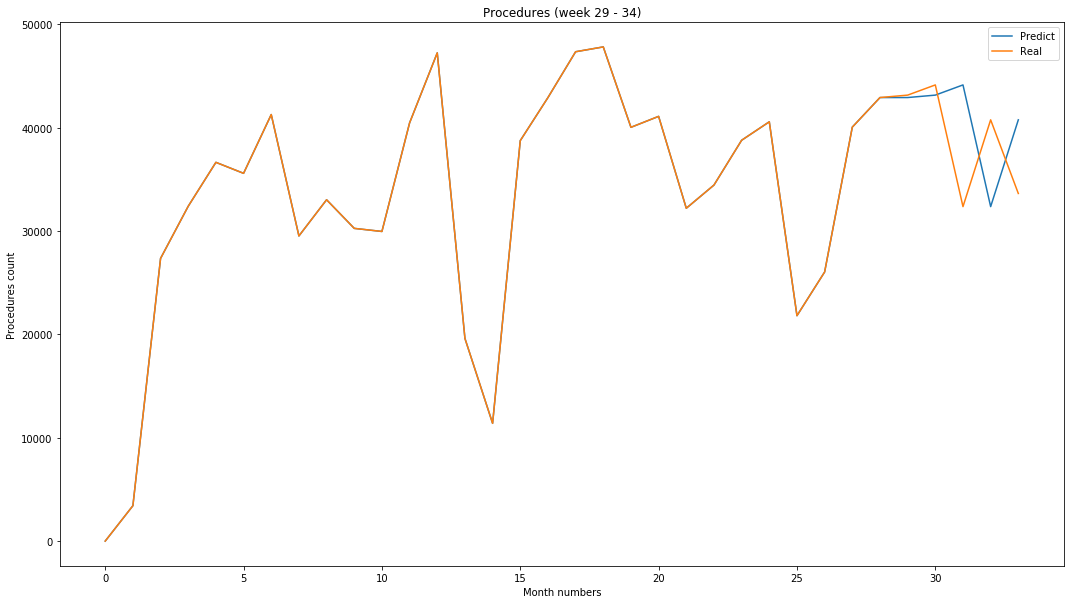

In [14]:

plt.plot(predict_ProcB)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

(20000, 50000)

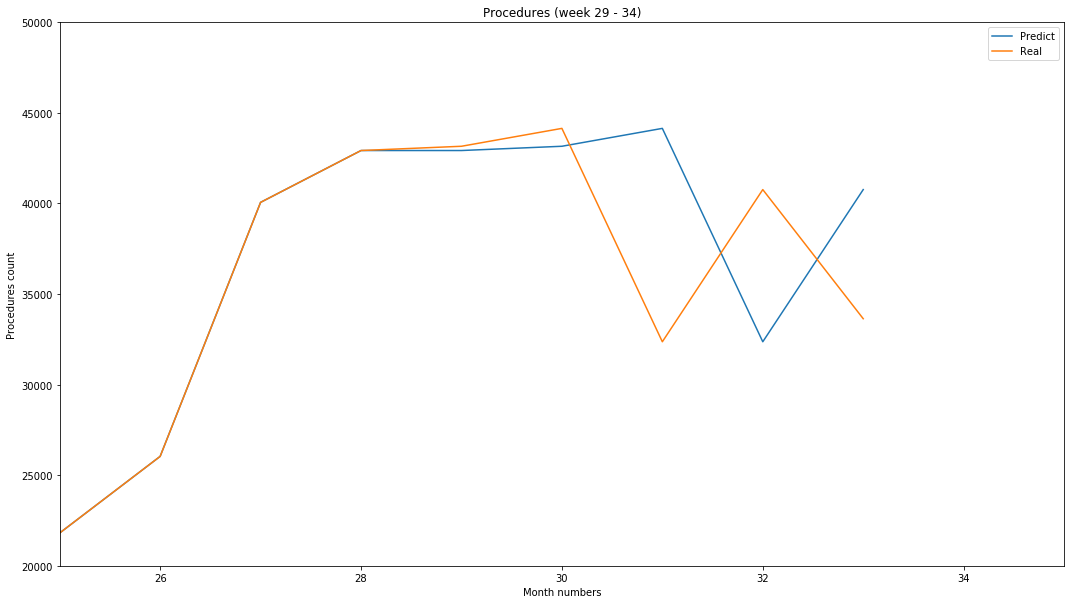

In [15]:
plt.plot(predict_ProcB)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

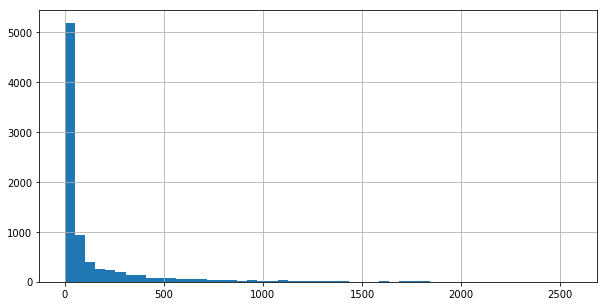

In [16]:
melt2['Proc'].hist(bins=50, figsize=(10,5))

In [17]:
%%time
mean_errorLR2 = []
mean_errorRF2 = []
mean_errorGB2 = []

mean_errorEC2 = []


total_errorLR2 = []
predict_ProcLR2 = copy.copy(procedures)
abs_pr_errorLR2 = []

total_errorRF2 = []
predict_ProcRF2 = copy.copy(procedures)
abs_pr_errorRF2 = []

total_errorGB2 = []
predict_ProcGB2 = copy.copy(procedures)
abs_pr_errorGB2 = []

total_errorEC2 = []
predict_ProcEC2 = copy.copy(procedures)
abs_pr_errorEC2 = []
for Month in range(month_start, month_end):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR2 = rmsle(yts, plr)
    abs_errorLR2 = abs(total_yts-total_plr)
    abs_prLR2 = abs_errorLR2/total_yts*100
    
    mean_errorLR2.append(errorLR2)
    total_errorLR2.append(abs_errorLR2)
    predict_ProcLR2.append(total_plr)
    abs_pr_errorLR2.append(abs_prLR2)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF2 = rmsle(yts, prf)
    abs_errorRF2 = abs(total_yts-total_prf)
    abs_prRF2 = abs_errorRF2/total_yts*100
    
    mean_errorRF2.append(errorRF2)
    total_errorRF2.append(abs_errorRF2)
    predict_ProcRF2.append(total_prf)
    abs_pr_errorRF2.append(abs_prRF2)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB2 = rmsle(yts, pgb)
    abs_errorGB2 = abs(total_yts-total_pgb)
    abs_prGB2 = abs_errorGB2/total_yts*100
    
    mean_errorGB2.append(errorGB2)
    total_errorGB2.append(abs_errorGB2)
    predict_ProcGB2.append(total_pgb)
    abs_pr_errorGB2.append(abs_prGB2)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC2=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC2)

    errorEC2 = rmsle(yts, pEC2)
    abs_errorEC2 = abs(total_yts-total_pec)
    abs_prEC2 = abs_errorEC2/total_yts*100
    
    mean_errorEC2.append(errorEC2)
    total_errorEC2.append(abs_errorEC2)
    predict_ProcEC2.append(total_pec)
    abs_pr_errorEC2.append(abs_prEC2)
    print('Month %d' % (Month))
    print('LR2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR2, total_yts, total_plr, abs_errorLR2, abs_prLR2))
    print('RF2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF2, total_yts, total_prf, abs_errorRF2, abs_prRF2))
    print('GB2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB2, total_yts, total_pgb, abs_errorGB2, abs_prGB2))
    print('EC2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC2, total_yts, total_pec, abs_errorEC2, abs_prEC2))
print('Mean Error')
print('LR2 = %.5f, RF2 = %.5f, GB2 = %.5f, EC2 = %.5f' % (np.mean(mean_errorLR2), np.mean(mean_errorRF2), np.mean(mean_errorGB2), np.mean(mean_errorEC2)))
print('Mean Abs Error')
print('LR2 = %.1f, RF2 = %.1f, GB2 = %.1f, EC2 = %.1f' % (np.mean(total_errorLR2), np.mean(total_errorRF2), np.mean(total_errorGB2), np.mean(total_errorEC2)))
print('Mean Abs Error persent')
print('LR2 = %.1f, RF2 = %.1f, GB2 = %.1f, EC2 = %.1f' % (np.mean(abs_pr_errorLR2), np.mean(abs_pr_errorRF2), np.mean(abs_pr_errorGB2), np.mean(abs_pr_errorEC2)))

Month 29
LR2 - Error 0.96383, Real Total 43153.0 - Predict Total 42662.6, Abs Error 490.4, Persent - 1.1
RF2 - Error 0.62911, Real Total 43153.0 - Predict Total 47061.5, Abs Error 3908.5, Persent - 9.1
GB2 - Error 0.50008, Real Total 43153.0 - Predict Total 44315.5, Abs Error 1162.5, Persent - 2.7
EC2 - Error 0.73146, Real Total 43153.0 - Predict Total 44679.9, Abs Error 1526.9, Persent - 3.5
Month 30
LR2 - Error 0.94858, Real Total 44140.0 - Predict Total 43152.0, Abs Error 988.0, Persent - 2.2
RF2 - Error 0.55070, Real Total 44140.0 - Predict Total 46246.1, Abs Error 2106.1, Persent - 4.8
GB2 - Error 0.44183, Real Total 44140.0 - Predict Total 41882.6, Abs Error 2257.4, Persent - 5.1
EC2 - Error 0.69219, Real Total 44140.0 - Predict Total 43760.2, Abs Error 379.8, Persent - 0.9
Month 31
LR2 - Error 1.11315, Real Total 32364.0 - Predict Total 44152.0, Abs Error 11788.0, Persent - 36.4
RF2 - Error 0.72617, Real Total 32364.0 - Predict Total 44633.9, Abs Error 12269.9, Persent - 37.9
GB

(20000, 50000)

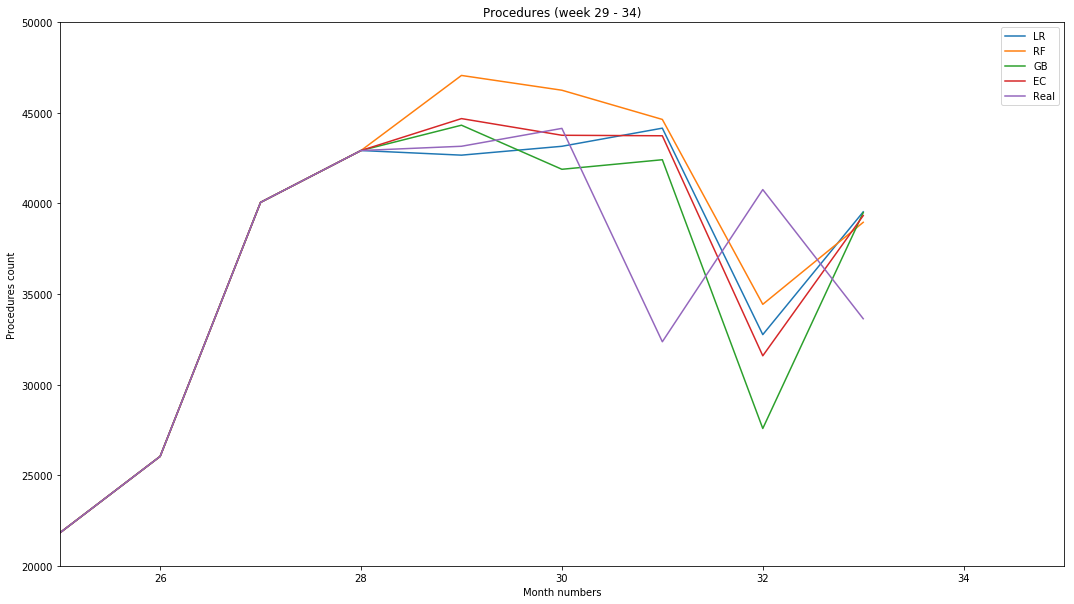

In [18]:
plt.plot(predict_ProcLR2)
plt.plot(predict_ProcRF2)
plt.plot(predict_ProcGB2)
plt.plot(predict_ProcEC2)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

In [19]:
melt3 = melt.copy()
melt3['Last_Month_Proc'] = melt3.groupby(['RegCode'])['Proc'].shift()
melt3['Last_Month_Diff'] = melt3.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt3['Last-1_Month_Proc'] = melt3.groupby(['RegCode'])['Proc'].shift(2)
melt3['Last-1_Month_Diff'] = melt3.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt3 = melt3.dropna()
melt3.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff,Last-1_Month_Proc,Last-1_Month_Diff
729,11,4,1,0.0,0.0,0.0,0.0
972,11,5,0,1.0,1.0,0.0,0.0
1215,11,6,0,0.0,-1.0,1.0,1.0
1458,11,7,0,0.0,0.0,0.0,-1.0
1701,11,8,0,0.0,0.0,0.0,0.0


In [20]:
%%time
mean_errorLR3 = []
mean_errorRF3 = []
mean_errorGB3 = []

mean_errorEC3 = []


total_errorLR3 = []
predict_ProcLR3 = copy.copy(procedures)
abs_pr_errorLR3 = []

total_errorRF3 = []
predict_ProcRF3 = copy.copy(procedures)
abs_pr_errorRF3 = []

total_errorGB3 = []
predict_ProcGB3 = copy.copy(procedures)
abs_pr_errorGB3 = []

total_errorEC3 = []
predict_ProcEC3 = copy.copy(procedures)
abs_pr_errorEC3 = []
for Month in range(month_start, month_end):
    train = melt3[melt3['Month'] < Month]
    val = melt3[melt3['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR3 = rmsle(yts, plr)
    abs_errorLR3 = abs(total_yts-total_plr)
    abs_prLR3 = abs_errorLR3/total_yts*100
    
    mean_errorLR3.append(errorLR3)
    total_errorLR3.append(abs_errorLR3)
    predict_ProcLR3.append(total_plr)
    abs_pr_errorLR3.append(abs_prLR3)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF3 = rmsle(yts, prf)
    abs_errorRF3 = abs(total_yts-total_prf)
    abs_prRF3 = abs_errorRF3/total_yts*100
    
    mean_errorRF3.append(errorRF3)
    total_errorRF3.append(abs_errorRF3)
    predict_ProcRF3.append(total_prf)
    abs_pr_errorRF3.append(abs_prRF3)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB3 = rmsle(yts, pgb)
    abs_errorGB3 = abs(total_yts-total_pgb)
    abs_prGB3 = abs_errorGB3/total_yts*100
    
    mean_errorGB3.append(errorGB3)
    total_errorGB3.append(abs_errorGB3)
    predict_ProcGB3.append(total_pgb)
    abs_pr_errorGB3.append(abs_prGB3)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC3=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC3)

    errorEC3 = rmsle(yts, pEC3)
    abs_errorEC3 = abs(total_yts-total_pec)
    abs_prEC3 = abs_errorEC3/total_yts*100
    
    mean_errorEC3.append(errorEC3)
    total_errorEC3.append(abs_errorEC3)
    predict_ProcEC3.append(total_pec)
    abs_pr_errorEC3.append(abs_prEC3)
    print('Month %d' % (Month))
    print('LR3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR3, total_yts, total_plr, abs_errorLR3, abs_prLR3))
    print('RF3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF3, total_yts, total_prf, abs_errorRF3, abs_prRF3))
    print('GB3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB3, total_yts, total_pgb, abs_errorGB3, abs_prGB3))
    print('EC3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC3, total_yts, total_pec, abs_errorEC3, abs_prEC3))
print('Mean Error')
print('LR3 = %.5f, RF3 = %.5f, GB3 = %.5f, EC3 = %.5f' % (np.mean(mean_errorLR3), np.mean(mean_errorRF3), np.mean(mean_errorGB3), np.mean(mean_errorEC3)))
print('Mean Abs Error')
print('LR3 = %.1f, RF3 = %.1f, GB3 = %.1f, EC3 = %.1f' % (np.mean(total_errorLR3), np.mean(total_errorRF3), np.mean(total_errorGB3), np.mean(total_errorEC3)))
print('Mean Abs Error persent')
print('LR3 = %.1f, RF3 = %.1f, GB3 = %.1f, EC3 = %.1f' % (np.mean(abs_pr_errorLR3), np.mean(abs_pr_errorRF3), np.mean(abs_pr_errorGB3), np.mean(abs_pr_errorEC3)))

Month 29
LR3 - Error 0.75479, Real Total 43153.0 - Predict Total 38073.1, Abs Error 5079.9, Persent - 11.8
RF3 - Error 0.55995, Real Total 43153.0 - Predict Total 42529.0, Abs Error 624.0, Persent - 1.4
GB3 - Error 0.47460, Real Total 43153.0 - Predict Total 43213.7, Abs Error 60.7, Persent - 0.1
EC3 - Error 0.59121, Real Total 43153.0 - Predict Total 41271.9, Abs Error 1881.1, Persent - 4.4
Month 30
LR3 - Error 0.83646, Real Total 44140.0 - Predict Total 42645.6, Abs Error 1494.4, Persent - 3.4
RF3 - Error 0.54768, Real Total 44140.0 - Predict Total 44710.8, Abs Error 570.8, Persent - 1.3
GB3 - Error 0.45246, Real Total 44140.0 - Predict Total 42669.5, Abs Error 1470.5, Persent - 3.3
EC3 - Error 0.63366, Real Total 44140.0 - Predict Total 43342.0, Abs Error 798.0, Persent - 1.8
Month 31
LR3 - Error 1.04988, Real Total 32364.0 - Predict Total 44207.8, Abs Error 11843.8, Persent - 36.6
RF3 - Error 0.72002, Real Total 32364.0 - Predict Total 44693.3, Abs Error 12329.3, Persent - 38.1
GB3

(20000, 50000)

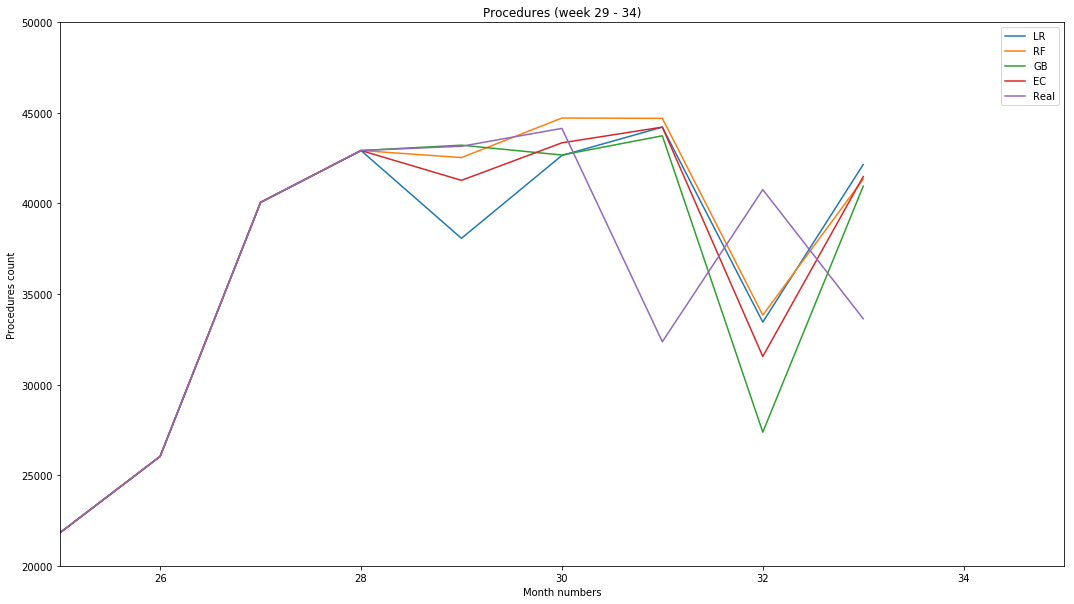

In [21]:
plt.plot(predict_ProcLR3)
plt.plot(predict_ProcRF3)
plt.plot(predict_ProcGB3)
plt.plot(predict_ProcEC3)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

In [22]:
melt4 = melt.copy()
melt4['Last_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift()
melt4['Last_Month_Diff'] = melt4.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt4['Last-1_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift(2)
melt4['Last-1_Month_Diff'] = melt4.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt4['Last-2_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift(3)
melt4['Last-2_Month_Diff'] = melt4.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt4 = melt4.dropna()
melt4.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff,Last-1_Month_Proc,Last-1_Month_Diff,Last-2_Month_Proc,Last-2_Month_Diff
972,11,5,0,1.0,1.0,0.0,0.0,0.0,0.0
1215,11,6,0,0.0,-1.0,1.0,1.0,0.0,0.0
1458,11,7,0,0.0,0.0,0.0,-1.0,1.0,1.0
1701,11,8,0,0.0,0.0,0.0,0.0,0.0,-1.0
1944,11,9,1,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
%%time
mean_errorLR4 = []
mean_errorRF4 = []
mean_errorGB4 = []

mean_errorEC4 = []


total_errorLR4 = []
predict_ProcLR4 = copy.copy(procedures)
abs_pr_errorLR4 = []

total_errorRF4 = []
predict_ProcRF4 = copy.copy(procedures)
abs_pr_errorRF4 = []

total_errorGB4 = []
predict_ProcGB4 = copy.copy(procedures)
abs_pr_errorGB4 = []

total_errorEC4 = []
predict_ProcEC4 = copy.copy(procedures)
abs_pr_errorEC4 = []
for Month in range(month_start, month_end):
    train = melt4[melt4['Month'] < Month]
    val = melt4[melt4['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR4 = rmsle(yts, plr)
    abs_errorLR4 = abs(total_yts-total_plr)
    abs_prLR4 = abs_errorLR4/total_yts*100
    
    mean_errorLR4.append(errorLR4)
    total_errorLR4.append(abs_errorLR4)
    predict_ProcLR4.append(total_plr)
    abs_pr_errorLR4.append(abs_prLR4)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF4 = rmsle(yts, prf)
    abs_errorRF4 = abs(total_yts-total_prf)
    abs_prRF4 = abs_errorRF4/total_yts*100
    
    mean_errorRF4.append(errorRF4)
    total_errorRF4.append(abs_errorRF4)
    predict_ProcRF4.append(total_prf)
    abs_pr_errorRF4.append(abs_prRF4)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB4 = rmsle(yts, pgb)
    abs_errorGB4 = abs(total_yts-total_pgb)
    abs_prGB4 = abs_errorGB4/total_yts*100
    
    mean_errorGB4.append(errorGB4)
    total_errorGB4.append(abs_errorGB4)
    predict_ProcGB4.append(total_pgb)
    abs_pr_errorGB4.append(abs_prGB4)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC4=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC4)

    errorEC4 = rmsle(yts, pEC4)
    abs_errorEC4 = abs(total_yts-total_pec)
    abs_prEC4 = abs_errorEC4/total_yts*100
    
    mean_errorEC4.append(errorEC4)
    total_errorEC4.append(abs_errorEC4)
    predict_ProcEC4.append(total_pec)
    abs_pr_errorEC4.append(abs_prEC4)
    print('Month %d' % (Month))
    print('LR4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR4, total_yts, total_plr, abs_errorLR4, abs_prLR4))
    print('RF4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF4, total_yts, total_prf, abs_errorRF4, abs_prRF4))
    print('GB4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB4, total_yts, total_pgb, abs_errorGB4, abs_prGB4))
    print('EC4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC4, total_yts, total_pec, abs_errorEC4, abs_prEC4))
print('Mean Error')
print('LR4 = %.5f, RF4 = %.5f, GB4 = %.5f, EC4 = %.5f' % (np.mean(mean_errorLR4), np.mean(mean_errorRF4), np.mean(mean_errorGB4), np.mean(mean_errorEC4)))
print('Mean Abs Error')
print('LR4 = %.1f, RF4 = %.1f, GB4 = %.1f, EC4 = %.1f' % (np.mean(total_errorLR4), np.mean(total_errorRF4), np.mean(total_errorGB4), np.mean(total_errorEC4)))
print('Mean Abs Error persent')
print('LR4 = %.1f, RF4 = %.1f, GB4 = %.1f, EC4 = %.1f' % (np.mean(abs_pr_errorLR4), np.mean(abs_pr_errorRF4), np.mean(abs_pr_errorGB4), np.mean(abs_pr_errorEC4)))

Month 29
LR4 - Error 0.74085, Real Total 43153.0 - Predict Total 35796.0, Abs Error 7357.0, Persent - 17.0
RF4 - Error 0.51994, Real Total 43153.0 - Predict Total 39047.1, Abs Error 4105.9, Persent - 9.5
GB4 - Error 0.47479, Real Total 43153.0 - Predict Total 41011.5, Abs Error 2141.5, Persent - 5.0
EC4 - Error 0.56786, Real Total 43153.0 - Predict Total 38618.2, Abs Error 4534.8, Persent - 10.5
Month 30
LR4 - Error 0.86385, Real Total 44140.0 - Predict Total 40824.3, Abs Error 3315.7, Persent - 7.5
RF4 - Error 0.53214, Real Total 44140.0 - Predict Total 43572.4, Abs Error 567.6, Persent - 1.3
GB4 - Error 0.45710, Real Total 44140.0 - Predict Total 43239.6, Abs Error 900.4, Persent - 2.0
EC4 - Error 0.64614, Real Total 44140.0 - Predict Total 42545.4, Abs Error 1594.6, Persent - 3.6
Month 31
LR4 - Error 1.10269, Real Total 32364.0 - Predict Total 44766.2, Abs Error 12402.2, Persent - 38.3
RF4 - Error 0.71818, Real Total 32364.0 - Predict Total 44332.2, Abs Error 11968.2, Persent - 37.0

(20000, 50000)

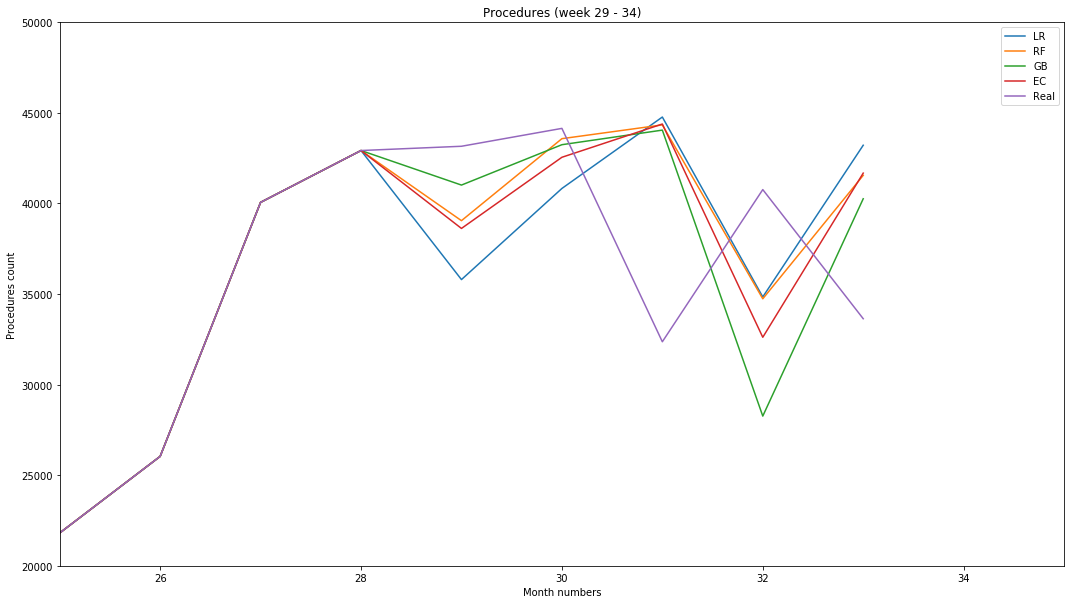

In [24]:
plt.plot(predict_ProcLR4)
plt.plot(predict_ProcRF4)
plt.plot(predict_ProcGB4)
plt.plot(predict_ProcEC4)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

In [25]:
%%time
mean_errorRF4_n = []
total_errorRF4_n = []
ProcRF4_n = copy.copy(procedures)
predict_ProcRF4_n = copy.copy(procedures)
abs_pr_errorRF4_n = []
for month in range(month_start, month_end):
    train = melt4[melt4['Month'] < month]
    val = melt4[melt4['Month'] == month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorRF4_n.append(error)
    total_errorRF4_n.append(abs_error)
    ProcRF4_n.append(total_yts)
    predict_ProcRF4_n.append(total_p)
    abs_pr_errorRF4_n.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorRF4_n))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF4_n))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF4_n))

Month 29 - Error 0.48457, Real Total 43153.0 - Predict Total 33508.5, Abs Error 9644.5, Persent - 22.3
Month 30 - Error 0.48097, Real Total 44140.0 - Predict Total 39294.2, Abs Error 4845.8, Persent - 11.0
Month 31 - Error 0.59015, Real Total 32364.0 - Predict Total 40586.3, Abs Error 8222.3, Persent - 25.4
Month 32 - Error 0.60305, Real Total 40762.0 - Predict Total 30170.8, Abs Error 10591.2, Persent - 26.0
Month 33 - Error 0.58722, Real Total 33636.0 - Predict Total 37144.5, Abs Error 3508.5, Persent - 10.4
Mean Error = 0.54919
Mean Abs Error = 7362.45326
Mean Abs Error persent = 19.02943
Wall time: 1min 13s


In [26]:
%%time
melt12 = melt.copy()
melt12['Last_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift()
melt12['Last_Month_Diff'] = melt12.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt12['Last-1_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(2)
melt12['Last-1_Month_Diff'] = melt12.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt12['Last-2_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-2_Month_Diff'] = melt12.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt12['Last-3_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-3_Month_Diff'] = melt12.groupby(['RegCode'])['Last-3_Month_Proc'].diff()
melt12['Last-4_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-4_Month_Diff'] = melt12.groupby(['RegCode'])['Last-4_Month_Proc'].diff()
melt12['Last-5_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-5_Month_Diff'] = melt12.groupby(['RegCode'])['Last-5_Month_Proc'].diff()
melt12['Last-6_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-6_Month_Diff'] = melt12.groupby(['RegCode'])['Last-6_Month_Proc'].diff()
melt12['Last-7_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-7_Month_Diff'] = melt12.groupby(['RegCode'])['Last-7_Month_Proc'].diff()
melt12['Last-8_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-8_Month_Diff'] = melt12.groupby(['RegCode'])['Last-8_Month_Proc'].diff()
melt12['Last-9_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-9_Month_Diff'] = melt12.groupby(['RegCode'])['Last-9_Month_Proc'].diff()
melt12['Last-10_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-10_Month_Diff'] = melt12.groupby(['RegCode'])['Last-10_Month_Proc'].diff()
melt12['Last-11_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(2)
melt12['Last-11_Month_Diff'] = melt12.groupby(['RegCode'])['Last-11_Month_Proc'].diff()
melt12['Last-12_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-12_Month_Diff'] = melt12.groupby(['RegCode'])['Last-12_Month_Proc'].diff()
melt12 = melt12.dropna()
melt12.head()

Wall time: 911 ms


In [27]:
%%time
mean_errorLR12 = []
mean_errorRF12 = []
mean_errorGB12 = []

mean_errorEC12 = []


total_errorLR12 = []
predict_ProcLR12 = copy.copy(procedures)
abs_pr_errorLR12 = []

total_errorRF12 = []
predict_ProcRF12 = copy.copy(procedures)
abs_pr_errorRF12 = []

total_errorGB12 = []
predict_ProcGB12 = copy.copy(procedures)
abs_pr_errorGB12 = []

total_errorEC12 = []
predict_ProcEC12 = copy.copy(procedures)
abs_pr_errorEC12 = []
for Month in range(month_start, month_end):
    train = melt12[melt12['Month'] < Month]
    val = melt12[melt12['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR12 = rmsle(yts, plr)
    abs_errorLR12 = abs(total_yts-total_plr)
    abs_prLR12 = abs_errorLR12/total_yts*100
    
    mean_errorLR12.append(errorLR12)
    total_errorLR12.append(abs_errorLR12)
    predict_ProcLR12.append(total_plr)
    abs_pr_errorLR12.append(abs_prLR12)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF12 = rmsle(yts, prf)
    abs_errorRF12 = abs(total_yts-total_prf)
    abs_prRF12 = abs_errorRF12/total_yts*100
    
    mean_errorRF12.append(errorRF12)
    total_errorRF12.append(abs_errorRF12)
    predict_ProcRF12.append(total_prf)
    abs_pr_errorRF12.append(abs_prRF12)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB12 = rmsle(yts, pgb)
    abs_errorGB12 = abs(total_yts-total_pgb)
    abs_prGB12 = abs_errorGB12/total_yts*100
    
    mean_errorGB12.append(errorGB12)
    total_errorGB12.append(abs_errorGB12)
    predict_ProcGB12.append(total_pgb)
    abs_pr_errorGB12.append(abs_prGB12)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC12=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC12)

    errorEC12 = rmsle(yts, pEC12)
    abs_errorEC12 = abs(total_yts-total_pec)
    abs_prEC12 = abs_errorEC12/total_yts*100
    
    mean_errorEC12.append(errorEC12)
    total_errorEC12.append(abs_errorEC12)
    predict_ProcEC12.append(total_pec)
    abs_pr_errorEC12.append(abs_prEC12)
    print('Month %d' % (Month))
    print('LR12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR12, total_yts, total_plr, abs_errorLR12, abs_prLR12))
    print('RF12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF12, total_yts, total_prf, abs_errorRF12, abs_prRF12))
    print('GB12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB12, total_yts, total_pgb, abs_errorGB12, abs_prGB12))
    print('EC12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC12, total_yts, total_pec, abs_errorEC12, abs_prEC12))
print('Mean Error')
print('LR12 = %.5f, RF12 = %.5f, GB12 = %.5f, EC12 = %.5f' % (np.mean(mean_errorLR12), np.mean(mean_errorRF12), np.mean(mean_errorGB12), np.mean(mean_errorEC12)))
print('Mean Abs Error')
print('LR12 = %.1f, RF12 = %.1f, GB12 = %.1f, EC12 = %.1f' % (np.mean(total_errorLR12), np.mean(total_errorRF12), np.mean(total_errorGB12), np.mean(total_errorEC12)))
print('Mean Abs Error persent')
print('LR12 = %.1f, RF12 = %.1f, GB12 = %.1f, EC12 = %.1f' % (np.mean(abs_pr_errorLR12), np.mean(abs_pr_errorRF12), np.mean(abs_pr_errorGB12), np.mean(abs_pr_errorEC12)))

Month 29
LR12 - Error 0.73261, Real Total 43153.0 - Predict Total 35838.2, Abs Error 7314.8, Persent - 17.0
RF12 - Error 0.51846, Real Total 43153.0 - Predict Total 38796.2, Abs Error 4356.8, Persent - 10.1
GB12 - Error 0.47479, Real Total 43153.0 - Predict Total 41011.5, Abs Error 2141.5, Persent - 5.0
EC12 - Error 0.56320, Real Total 43153.0 - Predict Total 38548.6, Abs Error 4604.4, Persent - 10.7
Month 30
LR12 - Error 0.85367, Real Total 44140.0 - Predict Total 40810.9, Abs Error 3329.1, Persent - 7.5
RF12 - Error 0.53322, Real Total 44140.0 - Predict Total 43506.0, Abs Error 634.0, Persent - 1.4
GB12 - Error 0.45710, Real Total 44140.0 - Predict Total 43239.6, Abs Error 900.4, Persent - 2.0
EC12 - Error 0.64076, Real Total 44140.0 - Predict Total 42518.8, Abs Error 1621.2, Persent - 3.7
Month 31
LR12 - Error 1.12162, Real Total 32364.0 - Predict Total 44734.5, Abs Error 12370.5, Persent - 38.2
RF12 - Error 0.71735, Real Total 32364.0 - Predict Total 44255.3, Abs Error 11891.3, Per

(20000, 50000)

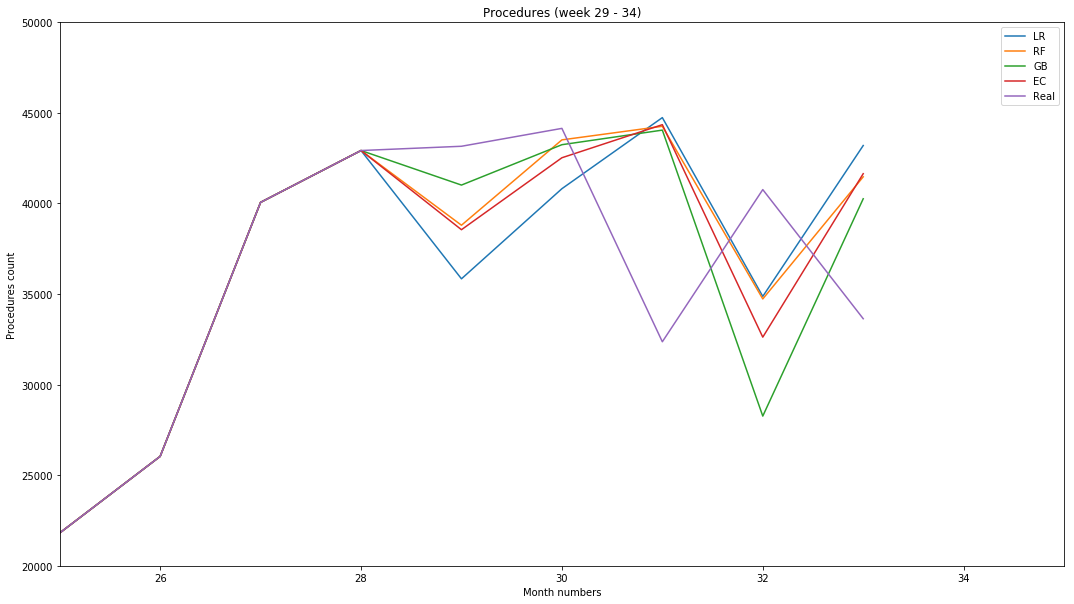

In [28]:
plt.plot(predict_ProcLR12)
plt.plot(predict_ProcRF12)
plt.plot(predict_ProcGB12)
plt.plot(predict_ProcEC12)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

C:\Users\a.solodov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\a.solodov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


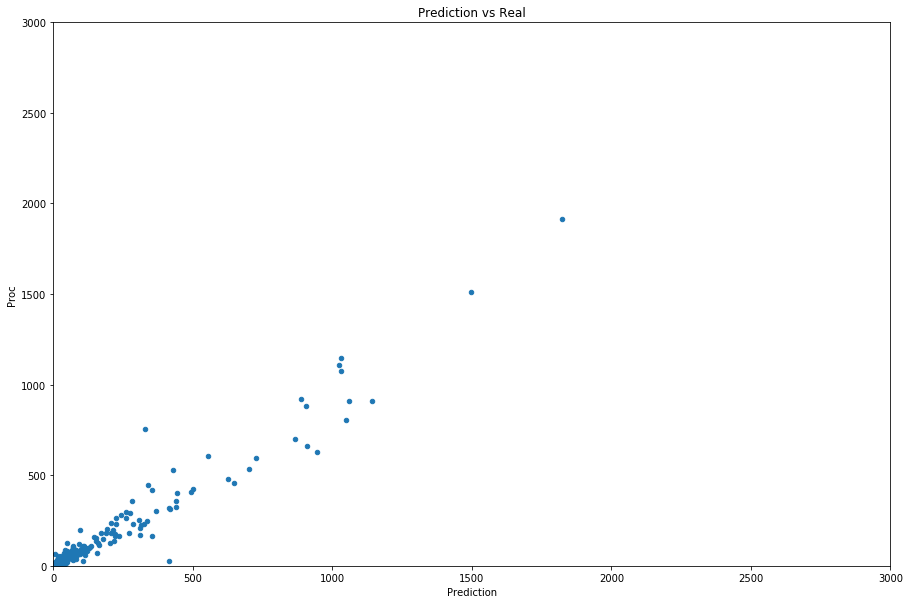

In [29]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Proc', figsize=(15,10), title='Prediction vs Real', 
                 ylim=(0,3000), xlim=(0,3000))

In [30]:
%%time
melt24 = melt.copy()
melt24['Last_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift()
melt24['Last_Month_Diff'] = melt24.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt24['Last-1_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-1_Month_Diff'] = melt24.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt24['Last-2_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-2_Month_Diff'] = melt24.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt24['Last-3_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-3_Month_Diff'] = melt24.groupby(['RegCode'])['Last-3_Month_Proc'].diff()
melt24['Last-4_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-4_Month_Diff'] = melt24.groupby(['RegCode'])['Last-4_Month_Proc'].diff()
melt24['Last-5_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-5_Month_Diff'] = melt24.groupby(['RegCode'])['Last-5_Month_Proc'].diff()
melt24['Last-6_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-6_Month_Diff'] = melt24.groupby(['RegCode'])['Last-6_Month_Proc'].diff()
melt24['Last-7_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-7_Month_Diff'] = melt24.groupby(['RegCode'])['Last-7_Month_Proc'].diff()
melt24['Last-8_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-8_Month_Diff'] = melt24.groupby(['RegCode'])['Last-8_Month_Proc'].diff()
melt24['Last-9_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-9_Month_Diff'] = melt24.groupby(['RegCode'])['Last-9_Month_Proc'].diff()
melt24['Last-10_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-10_Month_Diff'] = melt24.groupby(['RegCode'])['Last-10_Month_Proc'].diff()
melt24['Last-11_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-11_Month_Diff'] = melt24.groupby(['RegCode'])['Last-11_Month_Proc'].diff()
melt24['Last-12_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-12_Month_Diff'] = melt24.groupby(['RegCode'])['Last-12_Month_Proc'].diff()
melt24['Last-13_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-13_Month_Diff'] = melt24.groupby(['RegCode'])['Last-13_Month_Proc'].diff()
melt24['Last-14_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-14_Month_Diff'] = melt24.groupby(['RegCode'])['Last-14_Month_Proc'].diff()
melt24['Last-15_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-15_Month_Diff'] = melt24.groupby(['RegCode'])['Last-15_Month_Proc'].diff()
melt24['Last-16_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-16_Month_Diff'] = melt24.groupby(['RegCode'])['Last-16_Month_Proc'].diff()
melt24['Last-17_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-17_Month_Diff'] = melt24.groupby(['RegCode'])['Last-17_Month_Proc'].diff()
melt24['Last-18_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-18_Month_Diff'] = melt24.groupby(['RegCode'])['Last-18_Month_Proc'].diff()
melt24['Last-19_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-19_Month_Diff'] = melt24.groupby(['RegCode'])['Last-19_Month_Proc'].diff()
melt24['Last-20_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-20_Month_Diff'] = melt24.groupby(['RegCode'])['Last-20_Month_Proc'].diff()
melt24['Last-21_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-21_Month_Diff'] = melt24.groupby(['RegCode'])['Last-21_Month_Proc'].diff()
melt24['Last-22_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-22_Month_Diff'] = melt24.groupby(['RegCode'])['Last-22_Month_Proc'].diff()
melt24['Last-23_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-23_Month_Diff'] = melt24.groupby(['RegCode'])['Last-23_Month_Proc'].diff()
melt24['Last-24_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-24_Month_Diff'] = melt24.groupby(['RegCode'])['Last-24_Month_Proc'].diff()
melt24 = melt24.dropna()
melt24.head()

Wall time: 1.76 s


In [35]:
#Импортируем seaborn
import seaborn as sns

In [ ]:
#['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc']

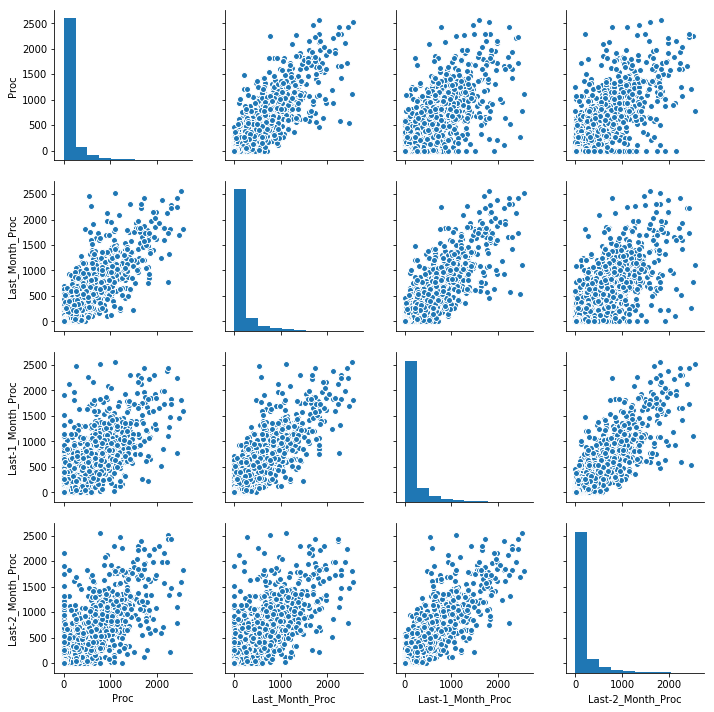

In [39]:
# c svg pairplot браузер начинает тормозить
%config InlineBackend.figure_format = 'png' 
#Построим зависимость сыгранных матчей, сделанных передач и набранных очков
sns_plot = sns.pairplot(
    melt24[['Proc', 'Last_Month_Proc', 'Last-1_Month_Proc', 'Last-2_Month_Proc']]);
sns_plot.savefig('pairplot.png')

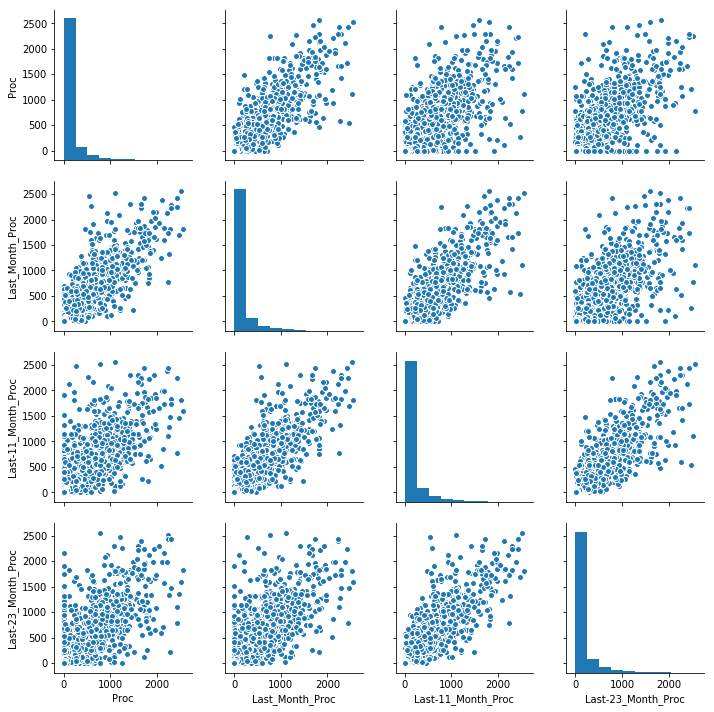

In [40]:
# c svg pairplot браузер начинает тормозить
%config InlineBackend.figure_format = 'png' 
#Построим зависимость сыгранных матчей, сделанных передач и набранных очков
sns_plot = sns.pairplot(
    melt24[['Proc', 'Last_Month_Proc', 'Last-11_Month_Proc', 'Last-23_Month_Proc']]);
sns_plot.savefig('pairplot.png')

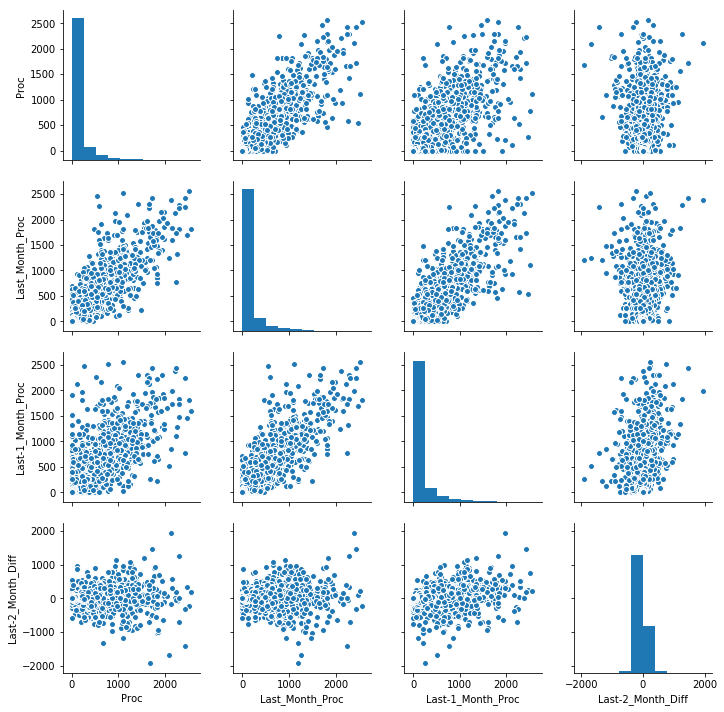

In [42]:
# c svg pairplot браузер начинает тормозить
%config InlineBackend.figure_format = 'png' 
#Построим зависимость сыгранных матчей, сделанных передач и набранных очков
sns_plot = sns.pairplot(
    melt24[['Proc', 'Last_Month_Proc', 'Last-1_Month_Proc', 'Last-2_Month_Diff']]);
sns_plot.savefig('pairplot.png')

In [31]:
%%time
mean_errorLR24 = []
mean_errorRF24 = []
mean_errorGB24 = []

mean_errorEC24 = []


total_errorLR24 = []
predict_ProcLR24 = copy.copy(procedures)
abs_pr_errorLR24 = []

total_errorRF24 = []
predict_ProcRF24 = copy.copy(procedures)
abs_pr_errorRF24 = []

total_errorGB24 = []
predict_ProcGB24 = copy.copy(procedures)
abs_pr_errorGB24 = []

total_errorEC24 = []
predict_ProcEC24 = copy.copy(procedures)
abs_pr_errorEC24 = []
for Month in range(month_start, month_end):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR24 = rmsle(yts, plr)
    abs_errorLR24 = abs(total_yts-total_plr)
    abs_prLR24 = abs_errorLR24/total_yts*100
    
    mean_errorLR24.append(errorLR24)
    total_errorLR24.append(abs_errorLR24)
    predict_ProcLR24.append(total_plr)
    abs_pr_errorLR24.append(abs_prLR24)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF24 = rmsle(yts, prf)
    abs_errorRF24 = abs(total_yts-total_prf)
    abs_prRF24 = abs_errorRF24/total_yts*100
    
    mean_errorRF24.append(errorRF24)
    total_errorRF24.append(abs_errorRF24)
    predict_ProcRF24.append(total_prf)
    abs_pr_errorRF24.append(abs_prRF24)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB24 = rmsle(yts, pgb)
    abs_errorGB24 = abs(total_yts-total_pgb)
    abs_prGB24 = abs_errorGB24/total_yts*100
    
    mean_errorGB24.append(errorGB24)
    total_errorGB24.append(abs_errorGB24)
    predict_ProcGB24.append(total_pgb)
    abs_pr_errorGB24.append(abs_prGB24)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC24=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC24)

    errorEC24 = rmsle(yts, pEC24)
    abs_errorEC24 = abs(total_yts-total_pec)
    abs_prEC24 = abs_errorEC24/total_yts*100
    
    mean_errorEC24.append(errorEC24)
    total_errorEC24.append(abs_errorEC24)
    predict_ProcEC24.append(total_pec)
    abs_pr_errorEC24.append(abs_prEC24)
    print('Month %d' % (Month))
    print('LR24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR24, total_yts, total_plr, abs_errorLR24, abs_prLR24))
    print('RF24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF24, total_yts, total_prf, abs_errorRF24, abs_prRF24))
    print('GB24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB24, total_yts, total_pgb, abs_errorGB24, abs_prGB24))
    print('EC24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC24, total_yts, total_pec, abs_errorEC24, abs_prEC24))
print('Mean Error')
print('LR24 = %.5f, RF24 = %.5f, GB24 = %.5f, EC24 = %.5f' % (np.mean(mean_errorLR24), np.mean(mean_errorRF24), np.mean(mean_errorGB24), np.mean(mean_errorEC24)))
print('Mean Abs Error')
print('LR24 = %.1f, RF24 = %.1f, GB24 = %.1f, EC24 = %.1f' % (np.mean(total_errorLR24), np.mean(total_errorRF24), np.mean(total_errorGB24), np.mean(total_errorEC24)))
print('Mean Abs Error persent')
print('LR24 = %.1f, RF24 = %.1f, GB24 = %.1f, EC24 = %.1f' % (np.mean(abs_pr_errorLR24), np.mean(abs_pr_errorRF24), np.mean(abs_pr_errorGB24), np.mean(abs_pr_errorEC24)))

Month 29
LR24 - Error 0.76767, Real Total 43153.0 - Predict Total 36027.8, Abs Error 7125.2, Persent - 16.5
RF24 - Error 0.51863, Real Total 43153.0 - Predict Total 38793.6, Abs Error 4359.4, Persent - 10.1
GB24 - Error 0.47479, Real Total 43153.0 - Predict Total 41011.5, Abs Error 2141.5, Persent - 5.0
EC24 - Error 0.58186, Real Total 43153.0 - Predict Total 38611.0, Abs Error 4542.0, Persent - 10.5
Month 30
LR24 - Error 0.85119, Real Total 44140.0 - Predict Total 40674.0, Abs Error 3466.0, Persent - 7.9
RF24 - Error 0.53306, Real Total 44140.0 - Predict Total 43491.0, Abs Error 649.0, Persent - 1.5
GB24 - Error 0.45710, Real Total 44140.0 - Predict Total 43239.6, Abs Error 900.4, Persent - 2.0
EC24 - Error 0.63925, Real Total 44140.0 - Predict Total 42468.2, Abs Error 1671.8, Persent - 3.8
Month 31
LR24 - Error 1.05978, Real Total 32364.0 - Predict Total 44078.7, Abs Error 11714.7, Persent - 36.2
RF24 - Error 0.71791, Real Total 32364.0 - Predict Total 44212.1, Abs Error 11848.1, Per

(20000, 50000)

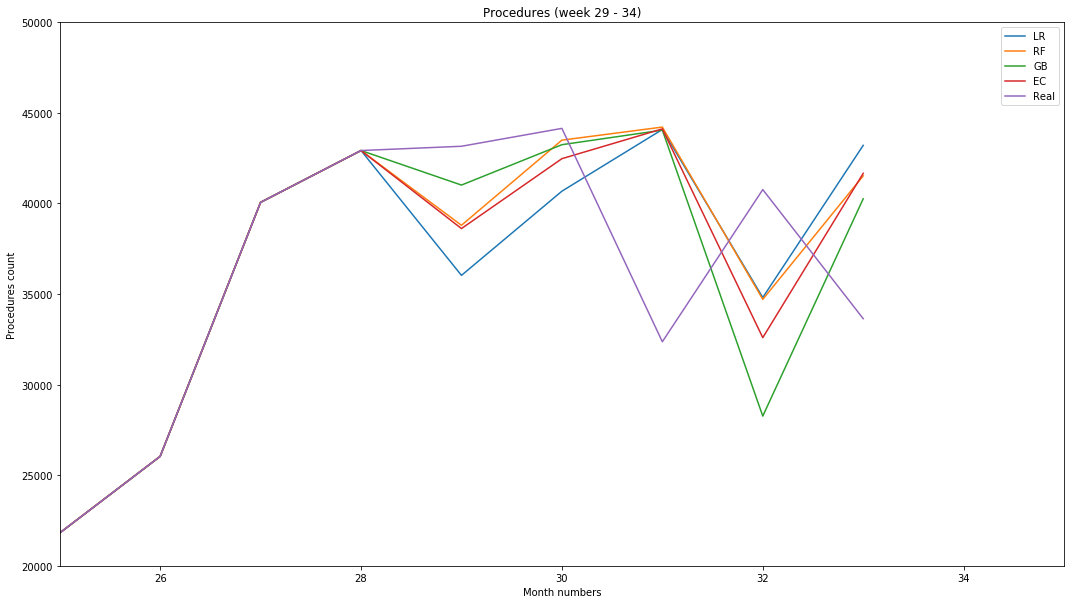

In [32]:
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(predict_ProcEC24)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

(20000, 70000)

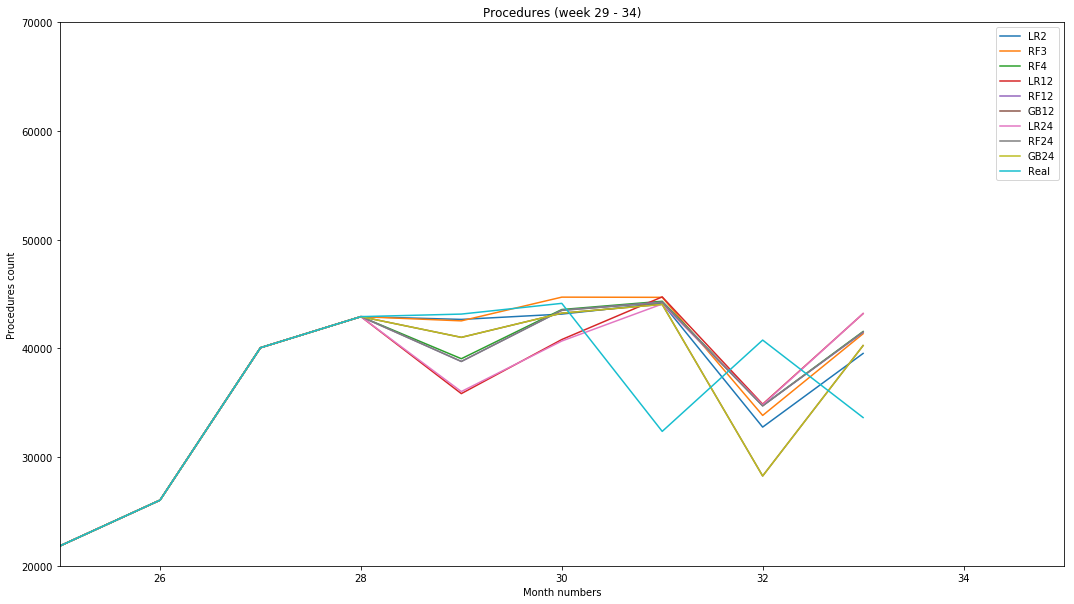

In [33]:
plt.plot(predict_ProcLR2)
plt.plot(predict_ProcRF3)
plt.plot(predict_ProcRF4)
plt.plot(predict_ProcLR12)
plt.plot(predict_ProcRF12)
plt.plot(predict_ProcGB12)
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(proceduresAll)

plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR2', 'RF3', 'RF4', 'LR12', 'RF12', 'GB12', 'LR24', 'RF24', 'GB24', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 70000)

In [34]:
print('Mean Error baseline = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error baseline = %.5f' % np.mean(total_errorB))
print('Mean Abs Error baseline persent = %.5f' % np.mean(abs_pr_errorB))
print('Mean Error LR2 = %.5f' % np.mean(mean_errorLR2))
print('Mean Abs Error LR2 = %.5f' % np.mean(total_errorLR2))
print('Mean Abs Error LR2 persent = %.5f' % np.mean(abs_pr_errorLR2))
print('Mean Error RF2 = %.5f' % np.mean(mean_errorRF2))
print('Mean Abs Error RF2 = %.5f' % np.mean(total_errorRF2))
print('Mean Abs Error RF2 persent = %.5f' % np.mean(abs_pr_errorRF2))
print('Mean Error RF3 = %.5f' % np.mean(mean_errorRF3))
print('Mean Abs Error RF3 = %.5f' % np.mean(total_errorRF3))
print('Mean Abs Error RF3 persent = %.5f' % np.mean(abs_pr_errorRF3))
print('Mean Error RF4 = %.5f' % np.mean(mean_errorRF4))
print('Mean Abs Error RF4 = %.5f' % np.mean(total_errorRF4))
print('Mean Abs Error RF4 persent = %.5f' % np.mean(abs_pr_errorRF4))
print('Mean Error RF4_n = %.5f' % np.mean(mean_errorRF4_n))
print('Mean Abs Error RF4_n = %.5f' % np.mean(total_errorRF4_n))
print('Mean Abs Error RF4_n persent = %.5f' % np.mean(abs_pr_errorRF4_n))
print('Mean Error GB4 = %.5f' % np.mean(mean_errorGB4))
print('Mean Abs Error GB4 = %.5f' % np.mean(total_errorGB4))
print('Mean Abs Error GB4 persent = %.5f' % np.mean(abs_pr_errorGB4))
print('Mean Error LR12 = %.5f' % np.mean(mean_errorLR12))
print('Mean Abs Error LR12 = %.5f' % np.mean(total_errorLR12))
print('Mean Abs Error LR12 persent = %.5f' % np.mean(abs_pr_errorLR12))
print('Mean Error = %.5f' % np.mean(mean_errorRF12))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF12))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF12))
print('Mean Error GB12 = %.5f' % np.mean(mean_errorGB12))
print('Mean Abs Error GB12 = %.5f' % np.mean(total_errorGB12))
print('Mean Abs Error GB12 persent = %.5f' % np.mean(abs_pr_errorGB12))
print('Mean Error LR24 = %.5f' % np.mean(mean_errorLR24))
print('Mean Abs Error LR24 = %.5f' % np.mean(total_errorLR24))
print('Mean Abs Error LR24 persent = %.5f' % np.mean(abs_pr_errorLR24))
print('Mean Error = %.5f' % np.mean(mean_errorRF24))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF24))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF24))
print('Mean Error GB24 = %.5f' % np.mean(mean_errorGB24))
print('Mean Abs Error GB24 = %.5f' % np.mean(total_errorGB24))
print('Mean Abs Error GB24 persent = %.5f' % np.mean(abs_pr_errorGB24))

Mean Error baseline = 0.55873
Mean Abs Error baseline = 5704.40000
Mean Abs Error baseline persent = 16.19098
Mean Error LR2 = 0.97497
Mean Abs Error LR2 = 5433.43813
Mean Abs Error LR2 persent = 15.39303
Mean Error RF2 = 0.63204
Mean Abs Error RF2 = 5987.21660
Mean Abs Error RF2 persent = 16.61807
Mean Error RF3 = 0.62066
Mean Abs Error RF3 = 5632.52740
Mean Abs Error RF3 persent = 16.15066
Mean Error RF4 = 0.60618
Mean Abs Error RF4 = 6116.06420
Mean Abs Error RF4 persent = 17.21760
Mean Error RF4_n = 0.54919
Mean Abs Error RF4_n = 7362.45326
Mean Abs Error RF4_n persent = 19.02943
Mean Error GB4 = 0.56412
Mean Abs Error GB4 = 6768.34372
Mean Abs Error GB4 persent = 18.68775
Mean Error LR12 = 0.89215
Mean Abs Error LR12 = 7693.48821
Mean Abs Error LR12 persent = 21.11884
Mean Error = 0.60557
Mean Abs Error = 6149.56860
Mean Abs Error persent = 17.27227
Mean Error GB12 = 0.56412
Mean Abs Error GB12 = 6768.34372
Mean Abs Error GB12 persent = 18.68775
Mean Error LR24 = 0.88494
Mean Abs 

In [35]:
cols = ['RegCode', 'Month', 'Last_Month_Proc', 'Last_Month_Diff',
       'Last-1_Month_Proc', 'Last-1_Month_Diff', 'Last-2_Month_Proc',
       'Last-2_Month_Diff', 'Last-3_Month_Proc', 'Last-3_Month_Diff',
       'Last-4_Month_Proc', 'Last-4_Month_Diff', 'Last-5_Month_Proc',
       'Last-5_Month_Diff', 'Last-6_Month_Proc', 'Last-6_Month_Diff',
       'Last-7_Month_Proc', 'Last-7_Month_Diff', 'Last-8_Month_Proc',
       'Last-8_Month_Diff', 'Last-9_Month_Proc', 'Last-9_Month_Diff',
       'Last-10_Month_Proc', 'Last-10_Month_Diff', 'Last-11_Month_Proc',
       'Last-11_Month_Diff', 'Last-12_Month_Proc', 'Last-12_Month_Diff',
       'Last-13_Month_Proc', 'Last-13_Month_Diff', 'Last-14_Month_Proc',
       'Last-14_Month_Diff', 'Last-15_Month_Proc', 'Last-15_Month_Diff',
       'Last-16_Month_Proc', 'Last-16_Month_Diff', 'Last-17_Month_Proc',
       'Last-17_Month_Diff', 'Last-18_Month_Proc', 'Last-18_Month_Diff',
       'Last-19_Month_Proc', 'Last-19_Month_Diff', 'Last-20_Month_Proc',
       'Last-20_Month_Diff', 'Last-21_Month_Proc', 'Last-21_Month_Diff',
       'Last-22_Month_Proc', 'Last-22_Month_Diff', 'Last-23_Month_Proc',
       'Last-23_Month_Diff', 'Last-24_Month_Proc', 'Last-24_Month_Diff']

In [36]:
%%time
#Заготовка под массив столбцов
c = []
colMeanError =[]
#Переменная под максимальное значение score
minErrorValue=100
colMeanAbsError =[]
bestPredictPorc_er = []
minAbsErrorValue=100
minAbsError=250000000000
bestPredictPorc_AbsEr = []
  
#Запоминаем длинну выборки столбцов - 1 (последний столбец - целевая переменная)
l=len(cols) - 1
#В трех циклах последовательно проходим по столбцам и формируем тройки, для каждой трокий делаем get_dummies для 
#перечислимых переменных, строим модель и вычисляем score.
#В переменных maxValue и bestParams сохраняем значения лучщего score и набор параметров, для которого он получился
bestCols = []
for i in range(0, l, 1):
    for j in range(i+1, l, 1):
        #Проверяем, что у нас нет одинаковых столбцов в выборке
        if cols[i]==cols[j]:
            continue
        c = []
        #Добавляем названия столбцов в выборку    
        c.append(cols[i])
        c.append(cols[j])
        mean_error = []
        total_error = []
        Proc = copy.copy(procedures)
        predict_Proc = copy.copy(procedures)
        abs_pr_error = []
        for Month in range(month_start, month_end):
            train = melt24[melt24['Month'] < Month]
            val = melt24[melt24['Month'] == Month]
            
            #Выделяем столбцы для эксперимента
            xtr, xts = train[c].values, val[c].values
            ytr, yts = train['Proc'].values, val['Proc'].values
                
            mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
            mdl.fit(xtr, ytr)
    
            p = mdl.predict(xts)
    
            total_yts=sum(yts)
            total_p=sum(p)
                
            error = rmsle(yts, p)
            abs_error = abs(total_yts-total_p)
            abs_pr = abs_error/total_yts*100

            #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
            mean_error.append(error)
            total_error.append(abs_error)
            Proc.append(total_yts)
            predict_Proc.append(total_p)
            abs_pr_error.append(abs_pr)
        MR = np.mean(mean_error)
        TR = np.mean(total_error)
        TRP = np.mean(abs_pr_error)
        print(c)
        print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
        if MR<minErrorValue:
            minErrorValue=MR
            colMeanError=c
            bestPredictPorc_er = predict_Proc
        if TRP<minAbsErrorValue:
            minAbsErrorValue=TRP
            colMeanAbsError=c
            bestPredictPorc_AbsEr = predict_Proc
        if TR<minAbsError:
            minAbsError=TR
            bestCols=c
            bestPredictPorc_AbsEr = predict_Proc
                

['RegCode', 'Month']
Mean Error 0.59739, Abs Error 5109.4, Abs Error Persent - 14.4
['RegCode', 'Last_Month_Proc']
Mean Error 0.60484, Abs Error 5455.1, Abs Error Persent - 15.5
['RegCode', 'Last_Month_Diff']
Mean Error 0.91857, Abs Error 6162.2, Abs Error Persent - 15.2
['RegCode', 'Last-1_Month_Proc']
Mean Error 0.65658, Abs Error 3487.1, Abs Error Persent - 10.0
['RegCode', 'Last-1_Month_Diff']
Mean Error 0.91125, Abs Error 5320.0, Abs Error Persent - 13.3
['RegCode', 'Last-2_Month_Proc']
Mean Error 0.75895, Abs Error 7262.7, Abs Error Persent - 19.7
['RegCode', 'Last-2_Month_Diff']
Mean Error 0.92642, Abs Error 3893.6, Abs Error Persent - 9.8
['RegCode', 'Last-3_Month_Proc']
Mean Error 0.75895, Abs Error 7262.7, Abs Error Persent - 19.7
['RegCode', 'Last-3_Month_Diff']
Mean Error 0.92642, Abs Error 3893.6, Abs Error Persent - 9.8
['RegCode', 'Last-4_Month_Proc']
Mean Error 0.75895, Abs Error 7262.7, Abs Error Persent - 19.7
['RegCode', 'Last-4_Month_Diff']
Mean Error 0.92642, Abs E

['Month', 'Last-18_Month_Proc']
Mean Error 0.90652, Abs Error 10435.4, Abs Error Persent - 27.7
['Month', 'Last-18_Month_Diff']
Mean Error 1.53503, Abs Error 7359.5, Abs Error Persent - 19.0
['Month', 'Last-19_Month_Proc']
Mean Error 0.90652, Abs Error 10435.4, Abs Error Persent - 27.7
['Month', 'Last-19_Month_Diff']
Mean Error 1.53503, Abs Error 7359.5, Abs Error Persent - 19.0
['Month', 'Last-20_Month_Proc']
Mean Error 0.90652, Abs Error 10435.4, Abs Error Persent - 27.7
['Month', 'Last-20_Month_Diff']
Mean Error 1.53503, Abs Error 7359.5, Abs Error Persent - 19.0
['Month', 'Last-21_Month_Proc']
Mean Error 0.77664, Abs Error 7791.5, Abs Error Persent - 20.3
['Month', 'Last-21_Month_Diff']
Mean Error 1.53081, Abs Error 11126.4, Abs Error Persent - 30.0
['Month', 'Last-22_Month_Proc']
Mean Error 0.90652, Abs Error 10435.4, Abs Error Persent - 27.7
['Month', 'Last-22_Month_Diff']
Mean Error 1.53503, Abs Error 7359.5, Abs Error Persent - 19.0
['Month', 'Last-23_Month_Proc']
Mean Error 0.

['Last_Month_Diff', 'Last-10_Month_Diff']
Mean Error 1.03239, Abs Error 5349.3, Abs Error Persent - 13.7
['Last_Month_Diff', 'Last-11_Month_Proc']
Mean Error 0.63935, Abs Error 5343.7, Abs Error Persent - 14.9
['Last_Month_Diff', 'Last-11_Month_Diff']
Mean Error 1.02754, Abs Error 7176.5, Abs Error Persent - 18.1
['Last_Month_Diff', 'Last-12_Month_Proc']
Mean Error 0.76042, Abs Error 9477.8, Abs Error Persent - 25.4
['Last_Month_Diff', 'Last-12_Month_Diff']
Mean Error 1.03239, Abs Error 5349.3, Abs Error Persent - 13.7
['Last_Month_Diff', 'Last-13_Month_Proc']
Mean Error 0.76042, Abs Error 9477.8, Abs Error Persent - 25.4
['Last_Month_Diff', 'Last-13_Month_Diff']
Mean Error 1.03239, Abs Error 5349.3, Abs Error Persent - 13.7
['Last_Month_Diff', 'Last-14_Month_Proc']
Mean Error 0.76042, Abs Error 9477.8, Abs Error Persent - 25.4
['Last_Month_Diff', 'Last-14_Month_Diff']
Mean Error 1.03239, Abs Error 5349.3, Abs Error Persent - 13.7
['Last_Month_Diff', 'Last-15_Month_Proc']
Mean Error 0.

['Last-1_Month_Diff', 'Last-4_Month_Proc']
Mean Error 0.70619, Abs Error 4814.4, Abs Error Persent - 13.0
['Last-1_Month_Diff', 'Last-4_Month_Diff']
Mean Error 1.03696, Abs Error 4030.6, Abs Error Persent - 10.3
['Last-1_Month_Diff', 'Last-5_Month_Proc']
Mean Error 0.70619, Abs Error 4814.4, Abs Error Persent - 13.0
['Last-1_Month_Diff', 'Last-5_Month_Diff']
Mean Error 1.03696, Abs Error 4030.6, Abs Error Persent - 10.3
['Last-1_Month_Diff', 'Last-6_Month_Proc']
Mean Error 0.70619, Abs Error 4814.4, Abs Error Persent - 13.0
['Last-1_Month_Diff', 'Last-6_Month_Diff']
Mean Error 1.03696, Abs Error 4030.6, Abs Error Persent - 10.3
['Last-1_Month_Diff', 'Last-7_Month_Proc']
Mean Error 0.70619, Abs Error 4814.4, Abs Error Persent - 13.0
['Last-1_Month_Diff', 'Last-7_Month_Diff']
Mean Error 1.03696, Abs Error 4030.6, Abs Error Persent - 10.3
['Last-1_Month_Diff', 'Last-8_Month_Proc']
Mean Error 0.70619, Abs Error 4814.4, Abs Error Persent - 13.0
['Last-1_Month_Diff', 'Last-8_Month_Diff']
Mea

['Last-2_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-2_Month_Proc', 'Last-21_Month_Proc']
Mean Error 0.71729, Abs Error 5093.0, Abs Error Persent - 13.9
['Last-2_Month_Proc', 'Last-21_Month_Diff']
Mean Error 0.70619, Abs Error 4814.4, Abs Error Persent - 13.0
['Last-2_Month_Proc', 'Last-22_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-2_Month_Proc', 'Last-22_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-2_Month_Proc', 'Last-23_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-2_Month_Proc', 'Last-23_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-2_Month_Proc', 'Last-24_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-2_Month_Diff', 'Last-3_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-2_Month_Diff', 'Last-3_Month_Di

['Last-3_Month_Proc', 'Last-16_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-3_Month_Proc', 'Last-17_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-3_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-3_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-3_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-3_Month_Proc', 'Last-19_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-3_Month_Proc', 'Last-19_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-3_Month_Proc', 'Last-20_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-3_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-3_Month_Proc', 'Last-21_Month_

['Last-4_Month_Proc', 'Last-14_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-4_Month_Proc', 'Last-15_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-4_Month_Proc', 'Last-15_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-4_Month_Proc', 'Last-16_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-4_Month_Proc', 'Last-16_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-4_Month_Proc', 'Last-17_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-4_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-4_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-4_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-4_Month_Proc', 'Last-19_Month_

['Last-5_Month_Proc', 'Last-14_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-5_Month_Proc', 'Last-15_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-5_Month_Proc', 'Last-15_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-5_Month_Proc', 'Last-16_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-5_Month_Proc', 'Last-16_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-5_Month_Proc', 'Last-17_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-5_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-5_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-5_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-5_Month_Proc', 'Last-19_Month_

['Last-6_Month_Proc', 'Last-16_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-6_Month_Proc', 'Last-17_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-6_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-6_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-6_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-6_Month_Proc', 'Last-19_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-6_Month_Proc', 'Last-19_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-6_Month_Proc', 'Last-20_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-6_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-6_Month_Proc', 'Last-21_Month_

['Last-7_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-7_Month_Proc', 'Last-21_Month_Proc']
Mean Error 0.71729, Abs Error 5093.0, Abs Error Persent - 13.9
['Last-7_Month_Proc', 'Last-21_Month_Diff']
Mean Error 0.70619, Abs Error 4814.4, Abs Error Persent - 13.0
['Last-7_Month_Proc', 'Last-22_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-7_Month_Proc', 'Last-22_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-7_Month_Proc', 'Last-23_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-7_Month_Proc', 'Last-23_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-7_Month_Proc', 'Last-24_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-7_Month_Diff', 'Last-8_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-7_Month_Diff', 'Last-8_Month_Di

['Last-8_Month_Diff', 'Last-11_Month_Proc']
Mean Error 0.71728, Abs Error 3200.9, Abs Error Persent - 8.8
['Last-8_Month_Diff', 'Last-11_Month_Diff']
Mean Error 1.03681, Abs Error 4034.6, Abs Error Persent - 10.3
['Last-8_Month_Diff', 'Last-12_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-8_Month_Diff', 'Last-12_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-8_Month_Diff', 'Last-13_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-8_Month_Diff', 'Last-13_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-8_Month_Diff', 'Last-14_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-8_Month_Diff', 'Last-14_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-8_Month_Diff', 'Last-15_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-8_Month_Diff', 'Last-15_Month_D

['Last-9_Month_Diff', 'Last-20_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-9_Month_Diff', 'Last-20_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-9_Month_Diff', 'Last-21_Month_Proc']
Mean Error 0.71728, Abs Error 3200.9, Abs Error Persent - 8.8
['Last-9_Month_Diff', 'Last-21_Month_Diff']
Mean Error 1.03681, Abs Error 4034.6, Abs Error Persent - 10.3
['Last-9_Month_Diff', 'Last-22_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-9_Month_Diff', 'Last-22_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-9_Month_Diff', 'Last-23_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-9_Month_Diff', 'Last-23_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-9_Month_Diff', 'Last-24_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-10_Month_Proc', 'Last-10_Month_

['Last-11_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.71729, Abs Error 5093.0, Abs Error Persent - 13.9
['Last-11_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.71723, Abs Error 3202.8, Abs Error Persent - 8.8
['Last-11_Month_Proc', 'Last-19_Month_Proc']
Mean Error 0.71729, Abs Error 5093.0, Abs Error Persent - 13.9
['Last-11_Month_Proc', 'Last-19_Month_Diff']
Mean Error 0.71723, Abs Error 3202.8, Abs Error Persent - 8.8
['Last-11_Month_Proc', 'Last-20_Month_Proc']
Mean Error 0.71729, Abs Error 5093.0, Abs Error Persent - 13.9
['Last-11_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.71723, Abs Error 3202.8, Abs Error Persent - 8.8
['Last-11_Month_Proc', 'Last-21_Month_Proc']
Mean Error 0.83023, Abs Error 3535.2, Abs Error Persent - 10.0
['Last-11_Month_Proc', 'Last-21_Month_Diff']
Mean Error 0.72316, Abs Error 5070.3, Abs Error Persent - 13.9
['Last-11_Month_Proc', 'Last-22_Month_Proc']
Mean Error 0.71729, Abs Error 5093.0, Abs Error Persent - 13.9
['Last-11_Month_Proc', 'Last-22

['Last-12_Month_Diff', 'Last-20_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-12_Month_Diff', 'Last-20_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-12_Month_Diff', 'Last-21_Month_Proc']
Mean Error 0.71728, Abs Error 3200.9, Abs Error Persent - 8.8
['Last-12_Month_Diff', 'Last-21_Month_Diff']
Mean Error 1.03681, Abs Error 4034.6, Abs Error Persent - 10.3
['Last-12_Month_Diff', 'Last-22_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-12_Month_Diff', 'Last-22_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-12_Month_Diff', 'Last-23_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-12_Month_Diff', 'Last-23_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-12_Month_Diff', 'Last-24_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-13_Month_Proc', 'Last-

['Last-14_Month_Diff', 'Last-17_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-14_Month_Diff', 'Last-17_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-14_Month_Diff', 'Last-18_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-14_Month_Diff', 'Last-18_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-14_Month_Diff', 'Last-19_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-14_Month_Diff', 'Last-19_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-14_Month_Diff', 'Last-20_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-14_Month_Diff', 'Last-20_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-14_Month_Diff', 'Last-21_Month_Proc']
Mean Error 0.71728, Abs Error 3200.9, Abs Error Persent - 8.8
['Last-14_Month_Diff', 'Last-

['Last-16_Month_Diff', 'Last-22_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-16_Month_Diff', 'Last-22_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-16_Month_Diff', 'Last-23_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-16_Month_Diff', 'Last-23_Month_Diff']
Mean Error 1.41096, Abs Error 5318.7, Abs Error Persent - 13.5
['Last-16_Month_Diff', 'Last-24_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-17_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-17_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-17_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-17_Month_Proc', 'Last-19_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-17_Month_Proc', 'Last

['Last-20_Month_Proc', 'Last-21_Month_Diff']
Mean Error 0.70619, Abs Error 4814.4, Abs Error Persent - 13.0
['Last-20_Month_Proc', 'Last-22_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-20_Month_Proc', 'Last-22_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-20_Month_Proc', 'Last-23_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-20_Month_Proc', 'Last-23_Month_Diff']
Mean Error 0.84103, Abs Error 7709.6, Abs Error Persent - 20.1
['Last-20_Month_Proc', 'Last-24_Month_Proc']
Mean Error 0.95351, Abs Error 8603.9, Abs Error Persent - 23.4
['Last-20_Month_Diff', 'Last-21_Month_Proc']
Mean Error 0.71728, Abs Error 3200.9, Abs Error Persent - 8.8
['Last-20_Month_Diff', 'Last-21_Month_Diff']
Mean Error 1.03681, Abs Error 4034.6, Abs Error Persent - 10.3
['Last-20_Month_Diff', 'Last-22_Month_Proc']
Mean Error 0.84102, Abs Error 7711.4, Abs Error Persent - 20.1
['Last-20_Month_Diff', 'Last-

In [37]:
print (minErrorValue)
print(colMeanAbsError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

0.5973895121504507
['Last-2_Month_Diff', 'Last-11_Month_Proc']
8.76527839805826
['Last-2_Month_Diff', 'Last-11_Month_Proc']
3200.859407781589
['Last-2_Month_Diff', 'Last-11_Month_Proc']


In [38]:
k = copy.copy(bestCols)
print(bestCols)

['Last-2_Month_Diff', 'Last-11_Month_Proc']


In [39]:
%%time
k = copy.copy(bestCols)
for j in range(0, l, 1):
    #Проверяем, что у нас нет одинаковых столбцов в выборке
    c = copy.copy(k)
    if cols[j] in c:
        continue
    c.append(cols[j])
    mean_error = []
    total_error = []
    Proc = copy.copy(procedures)
    predict_Proc = copy.copy(procedures)
    abs_pr_error = []
    for Month in range(month_start, month_end):
        train = melt24[melt24['Month'] < Month]
        val = melt24[melt24['Month'] == Month]
            
        #Выделяем столбцы для эксперимента
        xtr, xts = train[c].values, val[c].values
        ytr, yts = train['Proc'].values, val['Proc'].values
                
        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
    
        p = mdl.predict(xts)
    
        total_yts=sum(yts)
        total_p=sum(p)
                
        error = rmsle(yts, p)
        abs_error = abs(total_yts-total_p)
        abs_pr = abs_error/total_yts*100

        #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
        mean_error.append(error)
        total_error.append(abs_error)
        Proc.append(total_yts)
        predict_Proc.append(total_p)
        abs_pr_error.append(abs_pr)
    MR = np.mean(mean_error)
    TR = np.mean(total_error)
    TRP = np.mean(abs_pr_error)
    print(c)
    print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
    if MR<minErrorValue:
        minErrorValue=MR
        colMeanError=c
        bestPredictPorc_er = Proc
    if TRP<minAbsErrorValue:
        minAbsErrorValue=TRP
        colMeanAbsError=c
        bestPredictPorc_AbsEr = Proc
    if TR<minAbsError:
        minAbsError=TR
        bestCols=c
        bestPredictPorc_AbsEr = Proc

['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode']
Mean Error 0.64962, Abs Error 2841.9, Abs Error Persent - 7.9
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'Month']
Mean Error 0.72216, Abs Error 5836.8, Abs Error Persent - 15.6
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'Last_Month_Proc']
Mean Error 0.60053, Abs Error 5126.2, Abs Error Persent - 14.3
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'Last_Month_Diff']
Mean Error 0.60182, Abs Error 5074.3, Abs Error Persent - 14.0
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'Last-1_Month_Proc']
Mean Error 0.71838, Abs Error 3114.2, Abs Error Persent - 8.5
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'Last-1_Month_Diff']
Mean Error 0.68740, Abs Error 5189.7, Abs Error Persent - 13.7
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'Last-2_Month_Proc']
Mean Error 0.68522, Abs Error 5378.0, Abs Error Persent - 14.2
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'Last-3_Month_Proc']
Mean Error 0.68522, Abs Error 5378.0, Abs Error Persent - 14.2
['La

In [40]:
print (minErrorValue)
print(colMeanAbsError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

0.5973895121504507
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode']
7.898911813706064
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode']
2841.9095076539147
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode']


In [41]:
%%time
k = copy.copy(bestCols)
for j in range(0, l, 1):
    #Проверяем, что у нас нет одинаковых столбцов в выборке
    c = copy.copy(k)
    if cols[j] in c:
        continue
    c.append(cols[j])
    mean_error = []
    total_error = []
    Proc = copy.copy(procedures)
    predict_Proc = copy.copy(procedures)
    abs_pr_error = []
    for Month in range(month_start, month_end):
        train = melt24[melt24['Month'] < Month]
        val = melt24[melt24['Month'] == Month]
            
        #Выделяем столбцы для эксперимента
        xtr, xts = train[c].values, val[c].values
        ytr, yts = train['Proc'].values, val['Proc'].values
                
        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
    
        p = mdl.predict(xts)
    
        total_yts=sum(yts)
        total_p=sum(p)
                
        error = rmsle(yts, p)
        abs_error = abs(total_yts-total_p)
        abs_pr = abs_error/total_yts*100

        #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
        mean_error.append(error)
        total_error.append(abs_error)
        Proc.append(total_yts)
        predict_Proc.append(total_p)
        abs_pr_error.append(abs_pr)
    MR = np.mean(mean_error)
    TR = np.mean(total_error)
    TRP = np.mean(abs_pr_error)
    print(c)
    print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
    if MR<minErrorValue:
        minErrorValue=MR
        colMeanError=c
        bestPredictPorc_er = predict_Proc
    if TRP<minAbsErrorValue:
        minAbsErrorValue=TRP
        colMeanAbsError=c
        bestPredictPorc_AbsEr = predict_Proc
    if TR<minAbsError:
        minAbsError=TR
        bestCols=c
        bestPredictPorc_AbsEr = predict_Proc

['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Month']
Mean Error 0.70914, Abs Error 5014.2, Abs Error Persent - 13.4
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last_Month_Proc']
Mean Error 0.57731, Abs Error 5216.2, Abs Error Persent - 14.5
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last_Month_Diff']
Mean Error 0.58287, Abs Error 4895.0, Abs Error Persent - 13.6
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc']
Mean Error 0.64989, Abs Error 2774.3, Abs Error Persent - 7.7
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Diff']
Mean Error 0.64109, Abs Error 5250.6, Abs Error Persent - 14.1
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-2_Month_Proc']
Mean Error 0.63303, Abs Error 5337.5, Abs Error Persent - 14.2
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-3_Month_Proc']
Mean Error 0.63303, Abs Error 5337.5, Abs Error Persent - 14.2
['Last-2_Month_Diff', 'Last-11_Month_Proc', 

In [42]:
print (minErrorValue)
print(colMeanAbsError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

0.5773056113910938
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc']
7.713029942928877
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc']
2774.296372997835
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc']


In [43]:
%%time
k = copy.copy(bestCols)
for j in range(0, l, 1):
    #Проверяем, что у нас нет одинаковых столбцов в выборке
    c = copy.copy(k)
    if cols[j] in c:
        continue
    c.append(cols[j])
    mean_error = []
    total_error = []
    Proc = copy.copy(procedures)
    predict_Proc = copy.copy(procedures)
    abs_pr_error = []
    for Month in range(month_start, month_end):
        train = melt24[melt24['Month'] < Month]
        val = melt24[melt24['Month'] == Month]
            
        #Выделяем столбцы для эксперимента
        xtr, xts = train[c].values, val[c].values
        ytr, yts = train['Proc'].values, val['Proc'].values
                
        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
    
        p = mdl.predict(xts)
    
        total_yts=sum(yts)
        total_p=sum(p)
                
        error = rmsle(yts, p)
        abs_error = abs(total_yts-total_p)
        abs_pr = abs_error/total_yts*100

        #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
        mean_error.append(error)
        total_error.append(abs_error)
        Proc.append(total_yts)
        predict_Proc.append(total_p)
        abs_pr_error.append(abs_pr)
    MR = np.mean(mean_error)
    TR = np.mean(total_error)
    TRP = np.mean(abs_pr_error)
    print(c)
    print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
    if MR<minErrorValue:
        minErrorValue=MR
        colMeanError=c
        bestPredictPorc_er = predict_Proc
    if TRP<minAbsErrorValue:
        minAbsErrorValue=TRP
        colMeanAbsError=c
        bestPredictPorc_AbsEr = predict_Proc
    if TR<minAbsError:
        minAbsError=TR
        bestCols=c
        bestPredictPorc_AbsEr = predict_Proc

['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc', 'Month']
Mean Error 0.70946, Abs Error 4958.0, Abs Error Persent - 13.3
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc', 'Last_Month_Proc']
Mean Error 0.57699, Abs Error 5154.2, Abs Error Persent - 14.3
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc', 'Last_Month_Diff']
Mean Error 0.58309, Abs Error 4932.6, Abs Error Persent - 13.7
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc', 'Last-1_Month_Diff']
Mean Error 0.64141, Abs Error 5228.9, Abs Error Persent - 14.0
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc', 'Last-2_Month_Proc']
Mean Error 0.63181, Abs Error 5400.7, Abs Error Persent - 14.3
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc', 'Last-3_Month_Proc']
Mean Error 0.63181, Abs Error 5400.7, Abs Error Persent - 14.3
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', '

In [44]:
print (minErrorValue)
print(colMeanAbsError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

0.5769903541889797
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc']
7.713029942928877
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc']
2774.296372997835
['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc']


In [47]:
%%time
#Проверяем, что у нас нет одинаковых столбцов в выборке
c =['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc', 'Last_Month_Proc']
mean_error = []
total_error = []
Proc = copy.copy(procedures)
predict_ProcME = copy.copy(procedures)
abs_pr_error = []
for Month in range(month_start, month_end):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]
            
    #Выделяем столбцы для эксперимента
    xtr, xts = train[c].values, val[c].values
    ytr, yts = train['Proc'].values, val['Proc'].values
                
    mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
                
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    mean_error.append(error)
    total_error.append(abs_error)
    Proc.append(total_yts)
    predict_ProcME.append(total_p)
    abs_pr_error.append(abs_pr)
MR = np.mean(mean_error)
TR = np.mean(total_error)
TRP = np.mean(abs_pr_error)
print(c)
print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))

['Last-2_Month_Diff', 'Last-11_Month_Proc', 'RegCode', 'Last-1_Month_Proc', 'Last_Month_Proc']
Mean Error 0.57699, Abs Error 5154.2, Abs Error Persent - 14.3
Wall time: 21.2 s


C:\Users\a.solodov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\a.solodov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


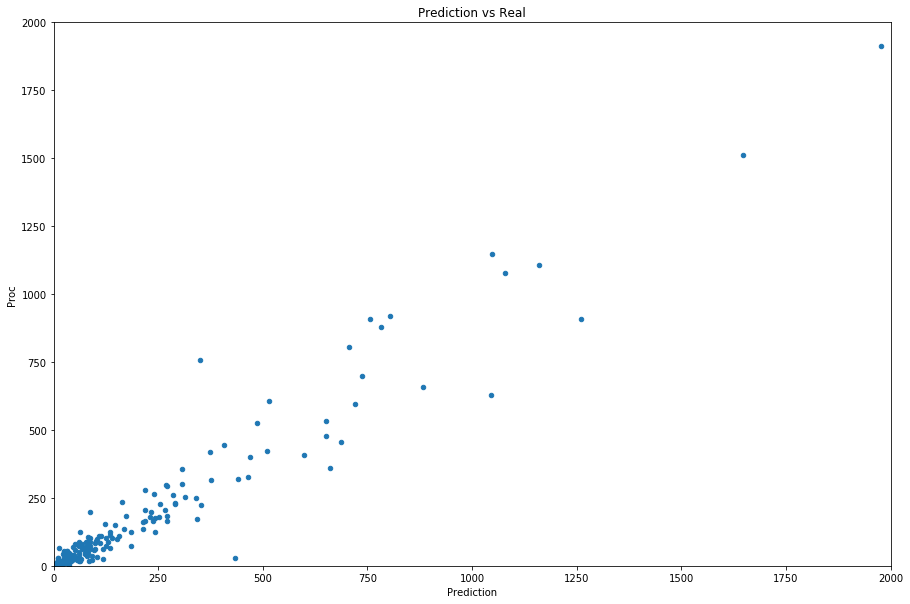

In [70]:

val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Proc', figsize=(15,10), title='Prediction vs Real', 
                 ylim=(0,2000), xlim=(0,2000))


(20000, 55000)

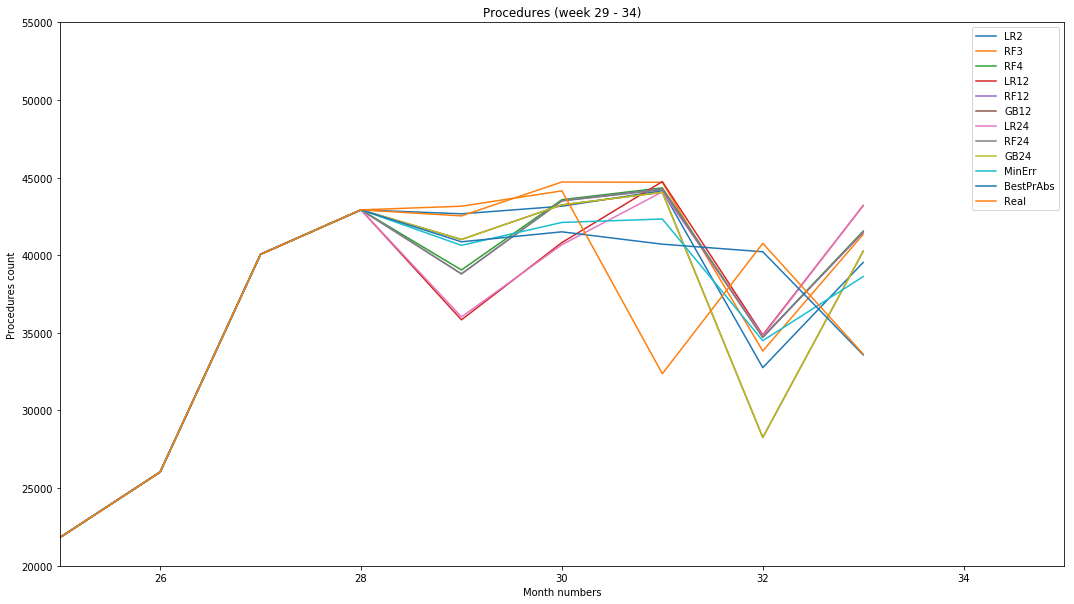

In [45]:
plt.plot(predict_ProcLR2)
plt.plot(predict_ProcRF3)
plt.plot(predict_ProcRF4)
plt.plot(predict_ProcLR12)
plt.plot(predict_ProcRF12)
plt.plot(predict_ProcGB12)
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(bestPredictPorc_er)
plt.plot(bestPredictPorc_AbsEr)
plt.plot(proceduresAll)

plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR2', 'RF3', 'RF4', 'LR12', 'RF12', 'GB12', 'LR24', 'RF24', 'GB24', 'MinErr', 'BestPrAbs', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 55000)

In [46]:
#Импортируем Plotly
from plotly.offline import init_notebook_mode, iplot
import c
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [47]:
B = pd.DataFrame({'B': predict_ProcB})
LR2 = pd.DataFrame({'LR2': predict_ProcLR2})
RF3 = pd.DataFrame({'RF3': predict_ProcRF3})
RF4 = pd.DataFrame({'RF4': predict_ProcRF4})
LR12 = pd.DataFrame({'LR12': predict_ProcLR12})
RF12 = pd.DataFrame({'RF12': predict_ProcRF12})
GB12 = pd.DataFrame({'GB12': predict_ProcGB12})
LR24 = pd.DataFrame({'LR24': predict_ProcLR24})
RF24 = pd.DataFrame({'RF24': predict_ProcRF24})
GB24 = pd.DataFrame({'GB24': predict_ProcGB24})

BE = pd.DataFrame({'BE': bestPredictPorc_er})
BAE = pd.DataFrame({'BAE': bestPredictPorc_AbsEr})
REAL = pd.DataFrame({'REAL': proceduresAll})

In [48]:
B.reset_index(inplace=True)
LR2.reset_index(inplace=True)
RF3.reset_index(inplace=True)
RF4.reset_index(inplace=True)
LR12.reset_index(inplace=True)
RF12.reset_index(inplace=True)
GB12.reset_index(inplace=True)
LR24.reset_index(inplace=True)
RF24.reset_index(inplace=True)
GB24.reset_index(inplace=True)
BE.reset_index(inplace=True)
BAE.reset_index(inplace=True)
REAL.reset_index(inplace=True)

In [49]:
LR2=LR2.merge( B, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF3, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF4, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( LR12, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF12, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( GB12, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( LR24, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF24, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( GB24, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( BE, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( BAE, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( REAL, how = 'inner', left_on = 'index', right_on = 'index' )


In [50]:
LR2 = LR2.tail(10)

In [51]:
#Строим графики
trace0 = go.Scatter(
    x=LR2.index,
    y=LR2.LR2,
    name='LR2'
)

trace1 = go.Scatter(
    x=LR2.index,
    y=LR2.RF3,
    name='RF3'
)

trace2 = go.Scatter(
    x=LR2.index,
    y=LR2.RF4,
    name='RF4'
)

trace3 = go.Scatter(
    x=LR2.index,
    y=LR2.LR12,
    name='LR12'
)

trace4 = go.Scatter(
    x=LR2.index,
    y=LR2.RF12,
    name='RF12'
)

trace5 = go.Scatter(
    x=LR2.index,
    y=LR2.GB12,
    name='GB12'
)
trace6 = go.Scatter(
    x=LR2.index,
    y=LR2.LR24,
    name='LR24'
)

trace7 = go.Scatter(
    x=LR2.index,
    y=LR2.RF24,
    name='RF24'
)

trace8 = go.Scatter(
    x=LR2.index,
    y=LR2.GB24,
    name='GB24'
)
trace9 = go.Scatter(
    x=LR2.index,
    y=LR2.BE,
    name='BE'
)

trace10 = go.Scatter(
    x=LR2.index,
    y=LR2.BAE,
    name='BAE'
)

trace11 = go.Scatter(
    x=LR2.index,
    y=LR2.REAL,
    name='REAL'
)

trace12 = go.Scatter(
    x=LR2.index,
    y=LR2.B,
    name='BASELINE'
)
data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9, trace10, trace11, trace12]
layout = {'title': 'Прогноз размещения'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

In [ ]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Proc', figsize=(15,10), title='Prediction vs Real', 
                 ylim=(0,3000), xlim=(0,3000))